In [7]:
% Adapted from tutorial written by 
% Tommy Sprague, 3/13/2015, originally for Bernstein Center workshop
% questions? tommy.sprague@gmail.com or jserences@ucsd.edu
% Added notes by JG (1/25/2016) and PS (11/29/2018)
%
% Uses a dataset graciously donated by Mary Smith, results form which were 
% presented at VSS 2015 (maryesmith@gmail.com).
%
% Please DO NOT use data from these tutorials without permission. Feel free
% to adapt or use code for teaching, research, etc. If possible, please
% acknowledge relevant publications introducing different components of these
% methods (Brouwer & Heeger, 2009; 2011; Sprague & Serences, 2013; 
% Sprague, Saproo & Serences, 2015)
%
% The general goal here is to generate an 'image' of the stimulus
% (sometimes called image reconstruction) that a subject is viewing. You
% can then ask questions about how the overall quality of the
% reconstruction changes as a function of contrast, attention or other task
% manipulations. 
% This has been applied for color (Brouwer & Heeger, 2009; 2013, J
% Neuro), orientation (e.g. Brouwer & Heeger, 2011, J Neurophys; Scolari et
% al, 2012, J Neuro; Ester et al, 2013, J Cog Neuro; Byers & Serences, 2014
% , J Neurophys), and motion direction
% (Saproo & Serences, 2014, J Neuro) and space (i.e. 2D image reconstruction,
% e.g. Sprague and Serences 2013 Nature Neuro)

<img src="procedure.png" width="550"/>
On each trial, each hemifield was presented with a randomly-chosen orientation (0:160 deg, measured clockwise from vertical). On each trial, participants were cued to attend to either the left grating or the right grating while fixating on the central dot. Let's try and reconstruct channel response functions for stimulus orientation across the attention conditions.


ans =

   288   209

size(myLbetas) -> 8 runs x 36 trials = 288 trials; 209 voxels

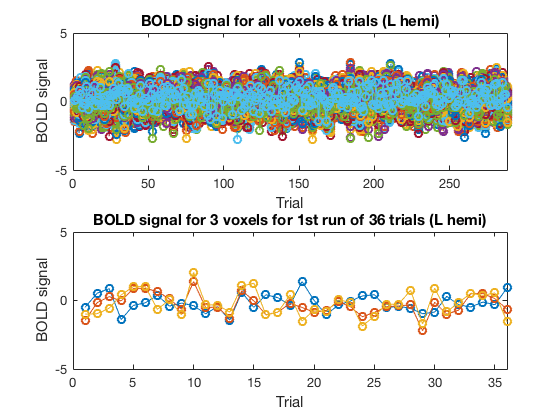

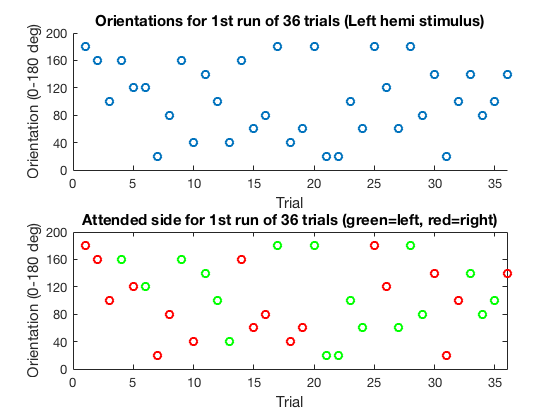

In [36]:
load('s03_data.mat'); %One subject's data

% Each data file contains:
% - myLBetas and myRBetas: n_trials x n_voxels signals extracted from each voxel of LH & RH V1, respectively

% - myOrL and myOrR: n_trials x 1 orientation labels for the orientation
%   presented on the left and right HEMISPHERES, respectively (opposite
%   side of screen; arranged this way for convenience)

% - myAttnSide: n_trials x 1, label for which side was attended (L or R, 1
%   or 2, respectively)

size(myLbetas) 
fprintf('size(myLbetas) -> 8 runs x 36 trials = 288 trials; 209 voxels')

subplot(2,1,1)
hold on;

% go from orientation label (1:9) to orientation value (20:180)
myOrL = myOrL-1;myOrR = myOrR-1;
myOrL(myOrL==0)=9; myOrR(myOrR==0)=9;
myOrL = myOrL*20; myOrR = myOrR*20;

plot(myOrL,'o');
xlabel('Trial');
ylabel('Orientation (0-180 deg)');
axis([0,36,0,200]);yticks(0:40:200);
title('Orientations for 1st run of 36 trials (Left hemi stimulus)');

subplot(2,1,2)
plot(find(myAttnSide==1),myOrL(myAttnSide==1),'go');
hold on; plot(find(myAttnSide==2),myOrL(myAttnSide==2),'ro');
axis([0,36,0,200]);yticks(0:40:200);
xlabel('Trial');
ylabel('Orientation (0-180 deg)');
title('Attended side for 1st run of 36 trials (green=left, red=right)');

figure();subplot(2,1,1)
plot(myLbetas,'o-'); 
xlabel('Trial');
ylabel('BOLD signal');
axis([0,288,-5 5])
title('BOLD signal for all voxels & trials (L hemi)');

subplot(2,1,2)
plot(myLbetas(1:36,1:3),'o-');
xlabel('Trial');
ylabel('BOLD signal');
axis([0,36,-5 5])
title('BOLD signal for 3 voxels for 1st run of 36 trials (L hemi)');


ans =

   180     9

size(basis_set) -> 180 orientations x 9 channels

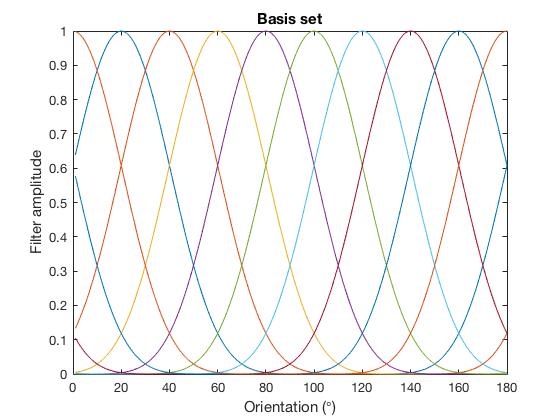

In [37]:
% Each data file contains 8 scanning runs, with 36 trials each. Let's create a
% variable which keeps track of run number for our cross-validation later on.

myScanNum = [];
for ii = 1:8
    myScanNum = [myScanNum; ii*ones(36,1)];
end

%% generate orientation channels (orientation filters)
%
% we're going to use orientation tuning functions (TFs), modeled as
% sinusoids raised to a high power. 

n_ori_chans = 9;

% each orientation channel can be modeled as a "steerable filter" (see
% Freeman and Adelson, 1991), which here is a (co)sinusoid raised to a high
% power (specifically, n_ori_chans-1). This particular shape isn't terribly
% important (I don't think, though others may disagree) - you'll get
% equally far modeling responses as Gaussians/von Mises functions, but
% we'll stick with the steerable filters here to keep things consistent w/
% our lab's prior work (and that of Gijs Brouwer & David Heeger). 

make_basis_function = @(xx,mu) (cosd(xx-mu)).^(n_ori_chans-mod(n_ori_chans,2));

% Let's look at our channels.

xx = linspace(1,180,180);
basis_set = nan(180,n_ori_chans);
chan_center = linspace(180/n_ori_chans,180,n_ori_chans);

for cc = 1:n_ori_chans
    basis_set(:,cc) = make_basis_function(xx,chan_center(cc));
end
size(basis_set)
fprintf('size(basis_set) -> 180 orientations x 9 channels')

plot(xx,basis_set);
xlabel('Orientation (\circ)');
ylabel('Filter amplitude');
title('Basis set');

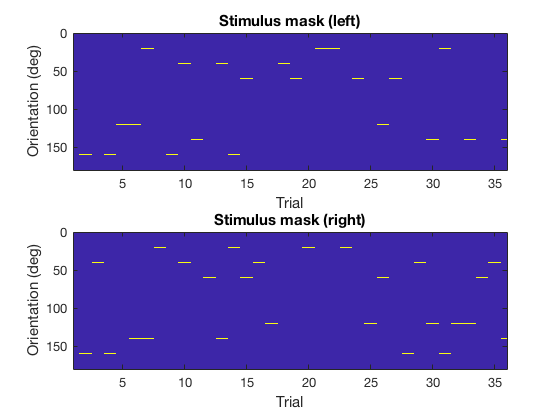

In [57]:
%% Voxel selection (refer back to the MVPA tutorial - same logic applies
% and you can use ANOVA, MI, etc for feature selection)
%
% For this tutorial, we'll implement voxel selection with a 1-way ANOVA
% just for simplicity in the model training/testing loop below
%
% Just remember that you should choose the set of voxels based only on the
% training data! 

%% Build stimulus mask
%
% we're creating an "image" of the portion of the feature space (orientation) occupied by 
% the visual stimulus for each set of voxels. Because we're analyzing each
% hemisphere separately here, we'll only consider the relevant orientation.
%
% The stimulus "image" should be the same dimensionality as the basis
% function vectors (here, 180 points). Because we're using square-wave,
% single-orientation gratings (that is, they have a single orientation
% value, and are not superimposed w/ other orientations as could be the
% case w/ plaids or other complex stimuli), we can consider the stimulus
% images to be a vector of 0's, w/ a single value of 1 at the stimulus
% orientation. Note that the basis set vectors and stimulus image can each
% be as high- or low-resolution as you like (down to n_channels values).
% Here, for convenience, we've simply used 180 points, 1 point for each
% degree.

% make stim_mask (each trial gets 180 values - 1 per deg; 0's for
% everything except actual orientation of that trial)
stim_mask_L = zeros(size(myOrL,1),length(xx));
stim_mask_R = zeros(size(myOrL,1),length(xx));
for tt = 1:size(stim_mask_L,1)  % loop over trials
    stim_mask_L(tt,myOrL(tt))=1;
    stim_mask_R(tt,myOrR(tt))=1;
end

% let's check our stimulus mask
subplot(2,1,1);
imagesc(stim_mask_L(1:36,:)');
title('Stimulus mask (left)');ylabel('Orientation (deg)');xlabel('Trial');
axis([1,36,0,180])
subplot(2,1,2);
imagesc(stim_mask_R(1:36,:)');
title('Stimulus mask (right)');ylabel('Orientation (deg)');xlabel('Trial');
axis([1,36,0,180])

In [86]:
%% Generate design matrix
%
% We're modeling each voxel as a linear combination of a set of hypothetical
% neural populations, or information channels, which are modeled as
% orientation TFs (see above). The set of TFs forms our "basis set" (see
% above), which is used to generate predictions for how each channel should
% respond to any given stimulus value. Let's generate those predictions as
% a matrix of trials x channels, called a "design matrix"
%
% Because we've computed "stimulus images", we just need to project each
% stimulus image onto the n_ori_chans basis functions. 

trnX_L = stim_mask_L*basis_set;
trnX_R = stim_mask_R*basis_set;

% We need to be sure our design matrix is full rank (that is,
% all channels are non-colinear, and that we can uniquely estimate the
% contribution of each channel to the signal observed in a given voxel). 

% rank function provides an estimate of the number of linearly independent rows or cols in a matrix
fprintf('Design matrix L: rank = %i\nDesign matrix R: rank = %i\n',rank(trnX_L),rank(trnX_R));

Design matrix L: rank = 9
Design matrix R: rank = 9


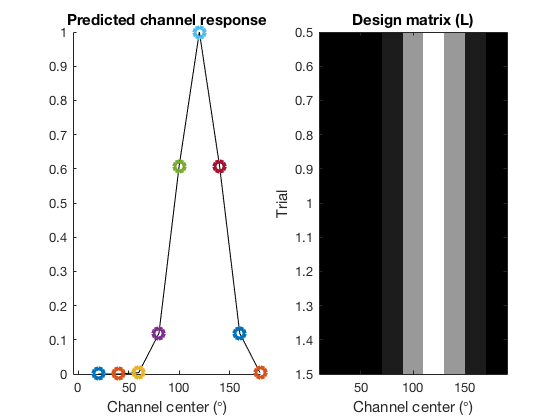

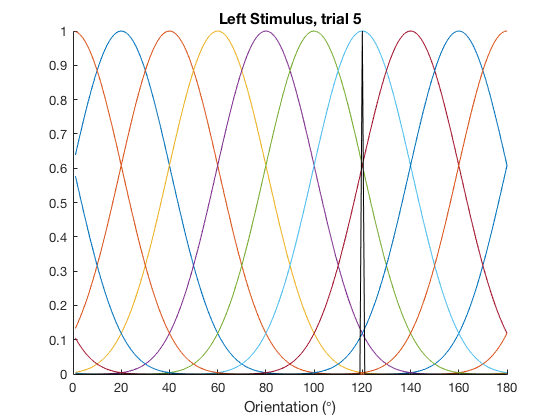

In [124]:
% let's look at the predicted response for a single trial (tr_num)
tr_num = 5;

% re-plot basis set
hold on;
plot(xx,basis_set);

% plot stim_mask for this trial
plot(xx,stim_mask_L(tr_num,:),'k-');
xlabel('Orientation (\circ)');title(sprintf('Left Stimulus, trial %i',tr_num));
xlim([0 180]);

% JG: re-plot stim_mask to convert to predicted channel response
figure();hold on;
plot(xx,stim_mask_L(tr_num,:),'r-');

% plot predicted channel response for this trial 
subplot(1,2,1);hold on;
plot(chan_center,trnX_L(tr_num,:),'k-');
for cc = 1:n_ori_chans
    plot(chan_center(cc),trnX_L(tr_num,cc),'o','MarkerSize',8,'LineWidth',3);
end
xlabel('Channel center (\circ)');title('Predicted channel response');
xlim([-5 180]);

% JG: plot design matrix for this trial
subplot(1,2,2);
imagesc(chan_center,1:size(trnX_L(tr_num,:),1),trnX_L(tr_num,:));
colormap(gray); %JG grayscale easier
title('Design matrix (L)');
xlabel('Channel center (\circ)');ylabel('Trial'); axis tight ij;

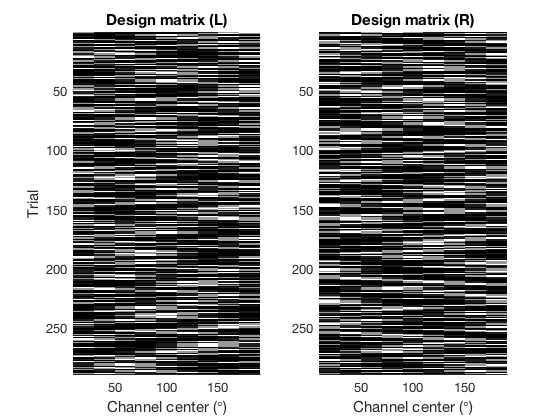

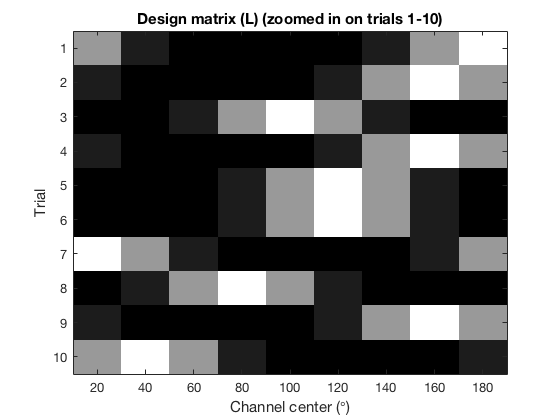

In [102]:
% JG: for trials 1:10
imagesc(chan_center,1:size(trnX_L(1:10,:),1),trnX_L(1:10,:));
colormap(gray); %JG grayscale easier
title('Design matrix (L) (zoomed in on trials 1-10)');
xlabel('Channel center (\circ)');ylabel('Trial'); axis tight ij;

% and each design matrix (all trials)
figure();subplot(1,2,1);hold on;
imagesc(chan_center,1:size(trnX_L,1),trnX_L);
colormap(gray); %JG grayscale easier
title('Design matrix (L)');
xlabel('Channel center (\circ)');ylabel('Trial'); axis tight ij;

subplot(1,2,2);hold on;
imagesc(chan_center,1:size(trnX_R,1),trnX_R);
title('Design matrix (R)');
xlabel('Channel center (\circ)'); axis tight ij;

In [113]:
%% Cross-validate and train/test encoding model within each hemisphere
%
% As with any machine learning or model-fitting it's important to be sure
% the data used to estimate a model (the weights for each voxel) is
% entirely independent of the data used to evaluate the model's efficacy,
% or here, to reconstruct stimulus representations. Because we z-scored the
% timeseries of each voxel within each run during preprocessing, data
% within a run is not independent. So here, we'll implement a
% leave-one-run-out cross-validation scheme for encoding model estimation
% and reconstruction. We'll use runs 1-(n-1) for model estimation, then map
% activation patterns from run n into the feature space using the map
% computed from runs 1-(n-1).

vox_prctile = 50; %50; % use top this % of voxels from each hemisphere

ru = unique(myScanNum);
n_runs = length(ru);

chan_resp_L = nan(size(trnX_L));
for rr = 1:n_runs
    
    % identify the training & testing halves of the data
    trnIdx = myScanNum~=ru(rr);
    tstIdx = myScanNum==ru(rr);
    
    % voxel selection - compute ANOVA on each voxel, rank them, select top
    % n% of voxels
    ps = nan(size(myLbetas,2),1);
    for ii = 1:size(myLbetas,2)
        ps(ii) = anova1(myLbetas(trnIdx,ii),myOrL(trnIdx),'off');
    end
    
    % if using all voxels
    %which_vox = ones(size(myLbetas,2))==1;
    
    %which_vox = ps <= prctile(ps,50);
    which_vox = ps <= prctile(ps,vox_prctile);
    % JG: total voxels in example ROI = size(which_vox) -> 209; selected voxels = size(find(which_vox==1)) -> 105
    
    trnL = myLbetas(trnIdx,which_vox);
    tstL = myLbetas(tstIdx,which_vox);
    % JG: remember, myLbetas is trials x voxels. here we're taking the beta
    % weights for the selected training trials (7 runs = 252 trials) and selected voxels
    % (105), and for the selected testing trials (1 run = 36 trials) and selected voxels
    % (105)
    % so: 
    % trnL are actual beta weights for selected trials & voxels (from myLbetas)
    % trnX_L is design matrix from section above -> channel weights for each trial
    % to train model (below) we associate multi-voxel beta pattern with correct
    % labels (channels); [252 trials x 9 channels] / [252 trials
    % x 105 voxels] = [9 channels x 105 voxels]. This is w_L, the trained weight of
    % each voxel for each channel

    % train the encoding model (remember, each hemisphere is separate here,
    % so must do this for each hemisphere seperately - here, I'm just doing
    % LH, you can add RH)
    w_L = trnX_L(trnIdx,:)\trnL;
    
    % JG: now that we have the weights of each voxel x channel, we use
    % these to test the test trial set (compare the trained multi-voxel
    % channel weights to the actual beta weights for each test trial, and
    % predict the label (channel response)
    % [9 channels x 105 voxels] x [105 voxels x 36 trials] = [9 channels x
    % 36 trials] --> then we invert and do this for each run ([288 trials x
    % 9 channels])
    chan_resp_L(tstIdx,:) = (inv(w_L*w_L')*w_L*tstL').';

end

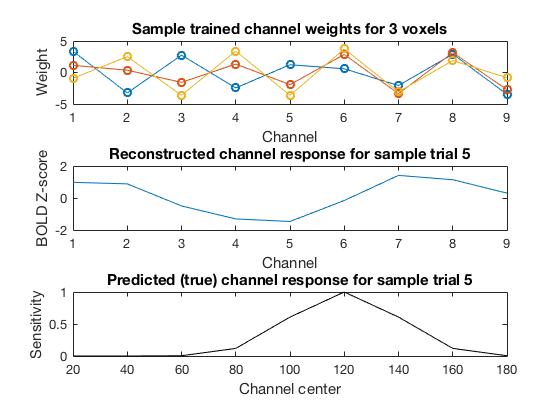

In [125]:
% plot weights for 3 voxels
subplot(3,1,1)
plot(w_L(:,1:3),'o-')
xlabel('Channel'); ylabel('Weight');
title('Sample trained channel weights for 3 voxels');

% plot reconstructed channel response for sample trial 
subplot(3,1,2)
plot(chan_resp_L(tr_num,:))
xlabel('Channel'); 
ylabel('BOLD Z-score'); 
title(['Reconstructed channel response for sample trial ' num2str(tr_num)]);

% how well did it do? compare to predicted channel response (design matrix) from fig 4
subplot(3,1,3)
plot(chan_center,trnX_L(tr_num,:),'k-');
xlabel('Channel center'); 
ylabel('Sensitivity'); 
title(['Predicted (true) channel response for sample trial ' num2str(tr_num)]);

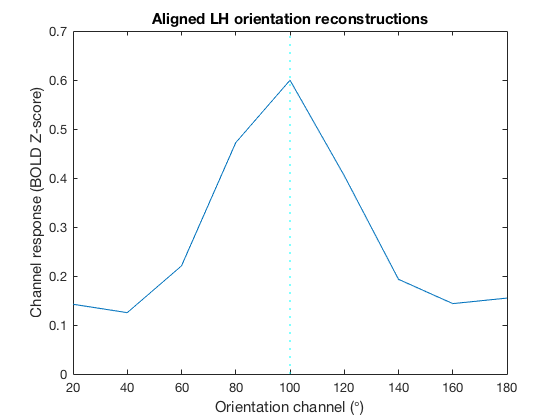

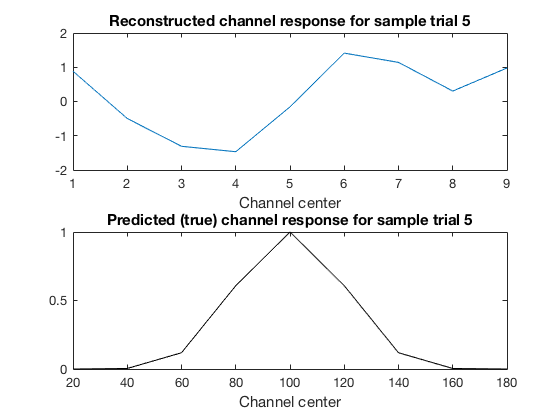

In [131]:
%% Combine channel response functions across orientations
%
% JG: now we want to see how well it reconstructed on average across all
% trials. but each trial had different "correct" orientation & channel
% response. so we want to align all predicted channel
% responses to same center, and do same for reconstructed channels


% The easiest way to do this is to circularly shift the channel response
% functions so that their centers are all aligned (say, at channel 5). 

ou = unique(myOrL);

targ_chan = ceil(n_ori_chans/2); %JG: target channel center is channel 5 (100deg) 

chan_resp_shift_L = nan(size(chan_resp_L));
for ii = 1:size(chan_resp_L,1)
    chan_resp_shift_L(ii,:) =  circshift(chan_resp_L(ii,:),targ_chan-find(ou==myOrL(ii)),2);
    trnX_shift_L(ii,:) =  circshift(trnX_L(ii,:),targ_chan-find(ou==myOrL(ii)),2); %JG added
end

% JG: re-plot same as above but with shifted channel responses
% plot reconstructed channel response for sample trial 
subplot(2,1,1)
plot(chan_resp_shift_L(tr_num,:))
xlabel('Channel center'); title(['Reconstructed channel response for sample trial ' num2str(tr_num)]);
subplot(2,1,2)
plot(chan_center,trnX_shift_L(tr_num,:),'k-');
xlabel('Channel center'); 
title(['Predicted (true) channel response for sample trial ' num2str(tr_num)]);

% JG: now plot average reconstructed response for all trials
figure();
plot(chan_center,mean(chan_resp_shift_L));
hold on;
plot([chan_center(targ_chan) chan_center(targ_chan)],[0 .7],':c') %JG added line at true ori 
xlabel('Orientation channel (\circ)');
ylabel('Channel response (BOLD Z-score)');
title('Aligned LH orientation reconstructions');

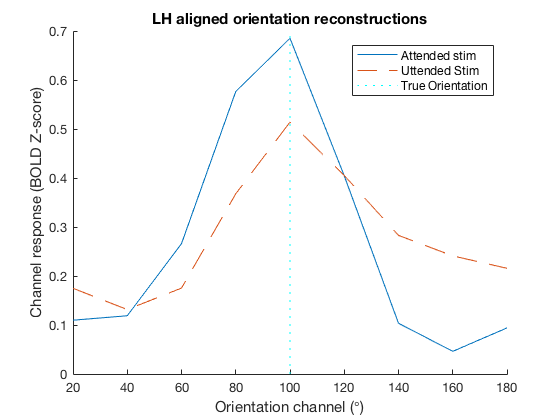

In [132]:
% now plot separately for attended vs unattended trials 
hold on;
plot(chan_center,    mean(chan_resp_shift_L(myAttnSide==2,:)),'-'); %JG: measuring from LH, so att_R is attn RVF (contra attended)
plot(chan_center,    mean(chan_resp_shift_L(myAttnSide==1,:)),'--'); %JG: measuring from LH, so att_L is attn LVF (contra unattended)
plot([chan_center(targ_chan) chan_center(targ_chan)],[0 .7],':c') %JG added line at true ori 
xlabel('Orientation channel (\circ)');
ylabel('Channel response (BOLD Z-score)');
title('LH aligned orientation reconstructions');
legend({'Attended stim', 'Uttended Stim','True Orientation'})

% now do all the model training/testing, plotting, etc for the other
% hemisphere. if you use cell arrays, there's a more efficient way to set
% this up than splitting into LH/RH variables!